1. Loads the data and removes rows with missing coordinates.
2. Combines date and time into a single datetime column.
3. Orders the data by user and timestamp.
4. Uses trackintel to generate triplegs based on sequential position fixes.



In [17]:
# Necessary imports
import pandas as pd
import numpy as np
import trackintel as ti
import geopandas as gpd
from shapely.geometry import Point, LineString
from datetime import timedelta

In [18]:
# Example file paths for each city
file_paths = {
    "CityA": "D:/lingyi/Documents/4032 data/4032-data/task1_dataset_kotae.csv",
    "CityB": "D:/lingyi/Documents/4032 data/4032-data/hiroshima_challengedata.csv",
    "CityC": "D:/lingyi/Documents/4032 data/4032-data/sapporo_challengedata.csv",
    "CityD": "D:/lingyi/Documents/4032 data/4032-data/kumamoto_challengedata.csv"
}

# Reference start date for calculation
reference_date = pd.to_datetime("2023-01-01")


In [19]:
# POI file paths
poi_files = {
    "CityA": "D:/lingyi/Documents/4032 data/4032-data/POIdata_cityA.csv",
    "CityB": "D:/lingyi/Documents/4032 data/4032-data/POIdata_cityB.csv",
    "CityC": "D:/lingyi/Documents/4032 data/4032-data/POIdata_cityC.csv",
    "CityD": "D:/lingyi/Documents/4032 data/4032-data/POIdata_cityD.csv"
}
# POI category file path
poi_categories_file = "D:/lingyi/Documents/4032 data/4032-data/POI_datacategories.csv"


In [20]:
# Define function to read and process POI data
def read_poi_data(file_path, categories_file):
    # Read POI data
    poi_data = pd.read_csv(file_path)
    poi_categories = pd.read_csv(categories_file, header=None, names=["category"])
    
    # Map category IDs to names
    poi_data["category_name"] = poi_data["category"].apply(
        lambda x: poi_categories.iloc[x - 1]["category"] if 0 < x <= len(poi_categories) else "Unknown"
    )
    
    # Convert to GeoDataFrame
    poi_data["geometry"] = [Point(xy) for xy in zip(poi_data["x"], poi_data["y"])]
    poi_gdf = gpd.GeoDataFrame(poi_data, geometry="geometry", crs="EPSG:3857")  # Assign initial CRS
    return poi_gdf

In [21]:
# Read POI data
poi_gdfs = {city: read_poi_data(poi_path, poi_categories_file) for city, poi_path in poi_files.items()}

<Figure size 1000x800 with 0 Axes>

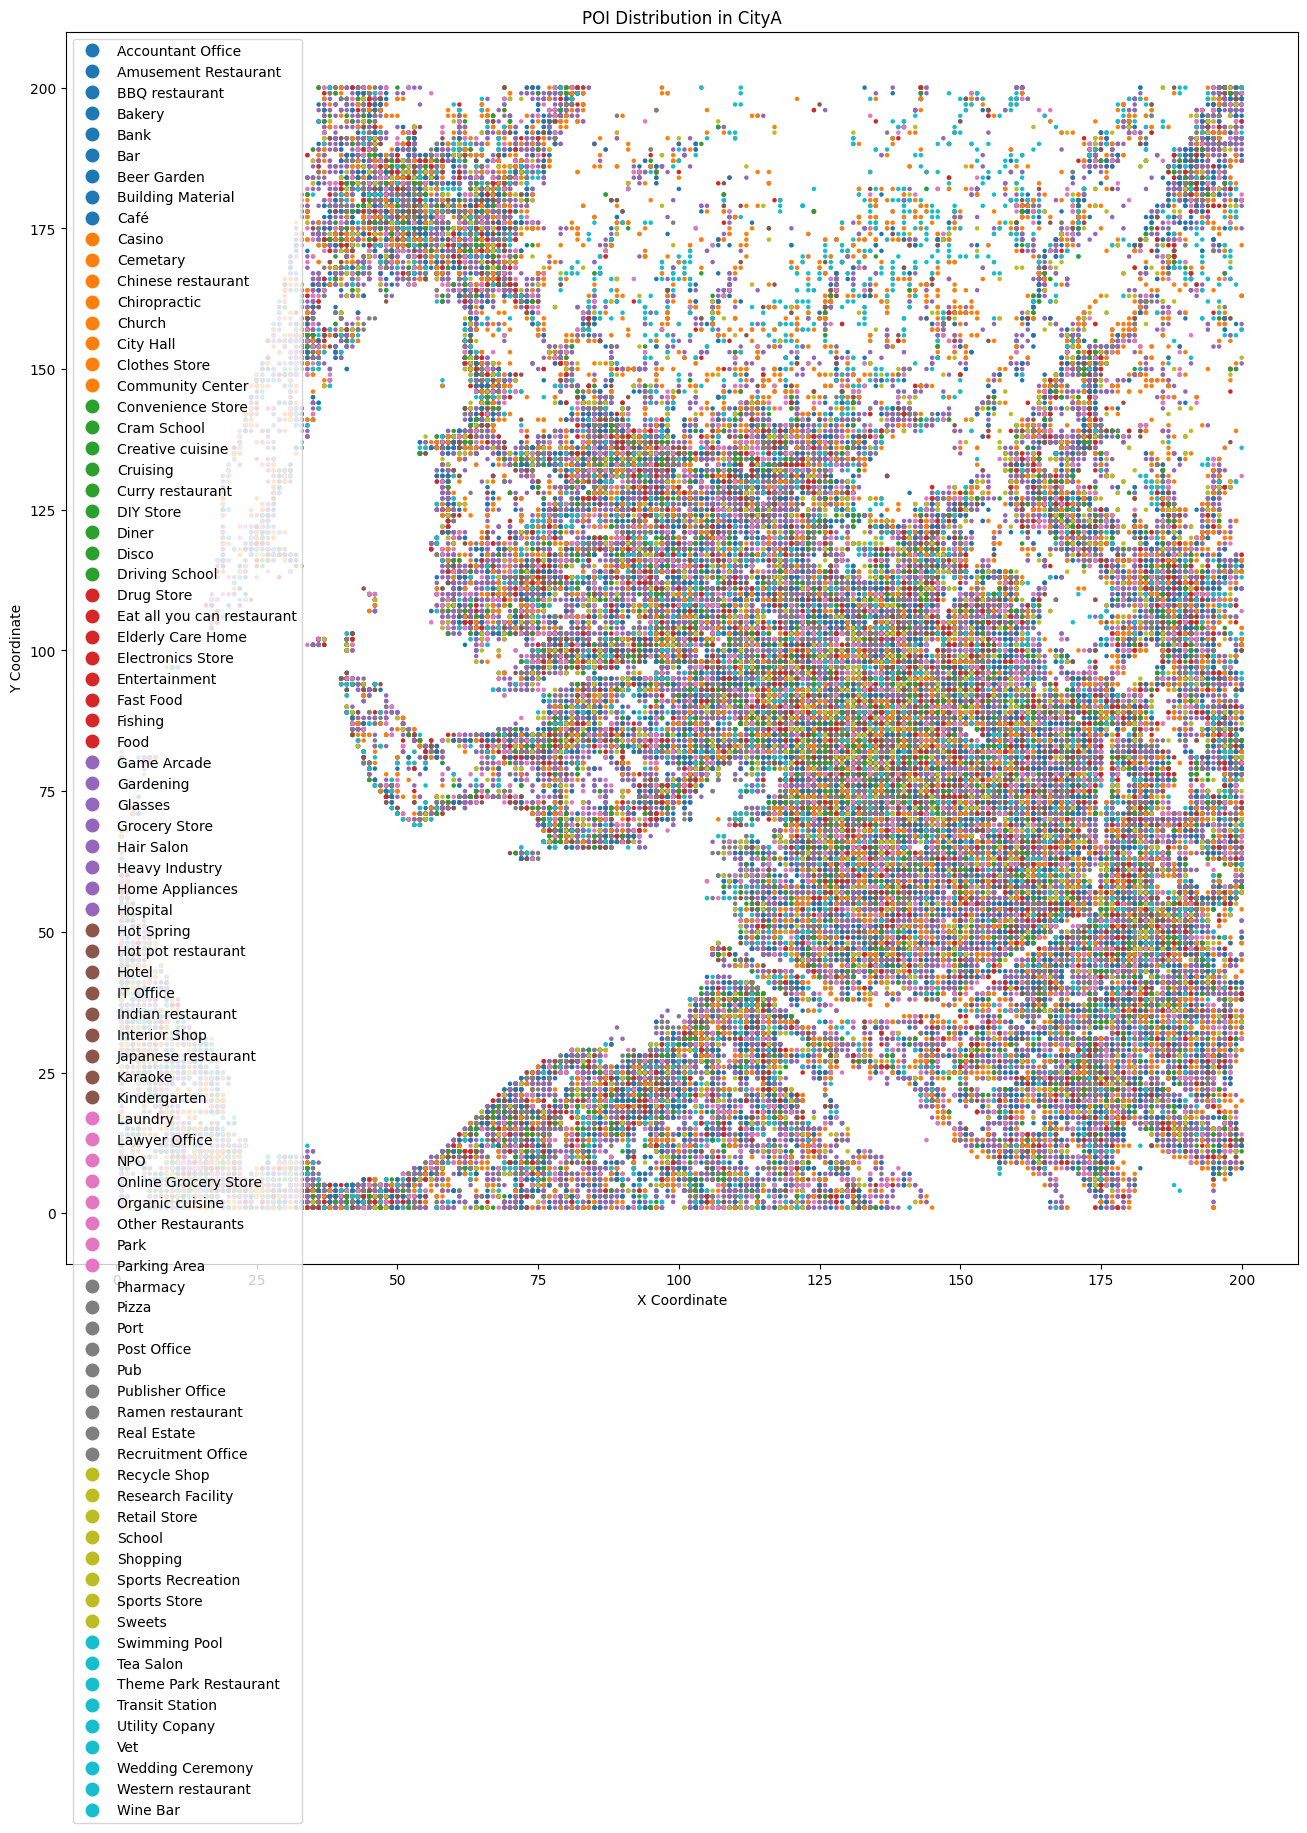

<Figure size 1000x800 with 0 Axes>

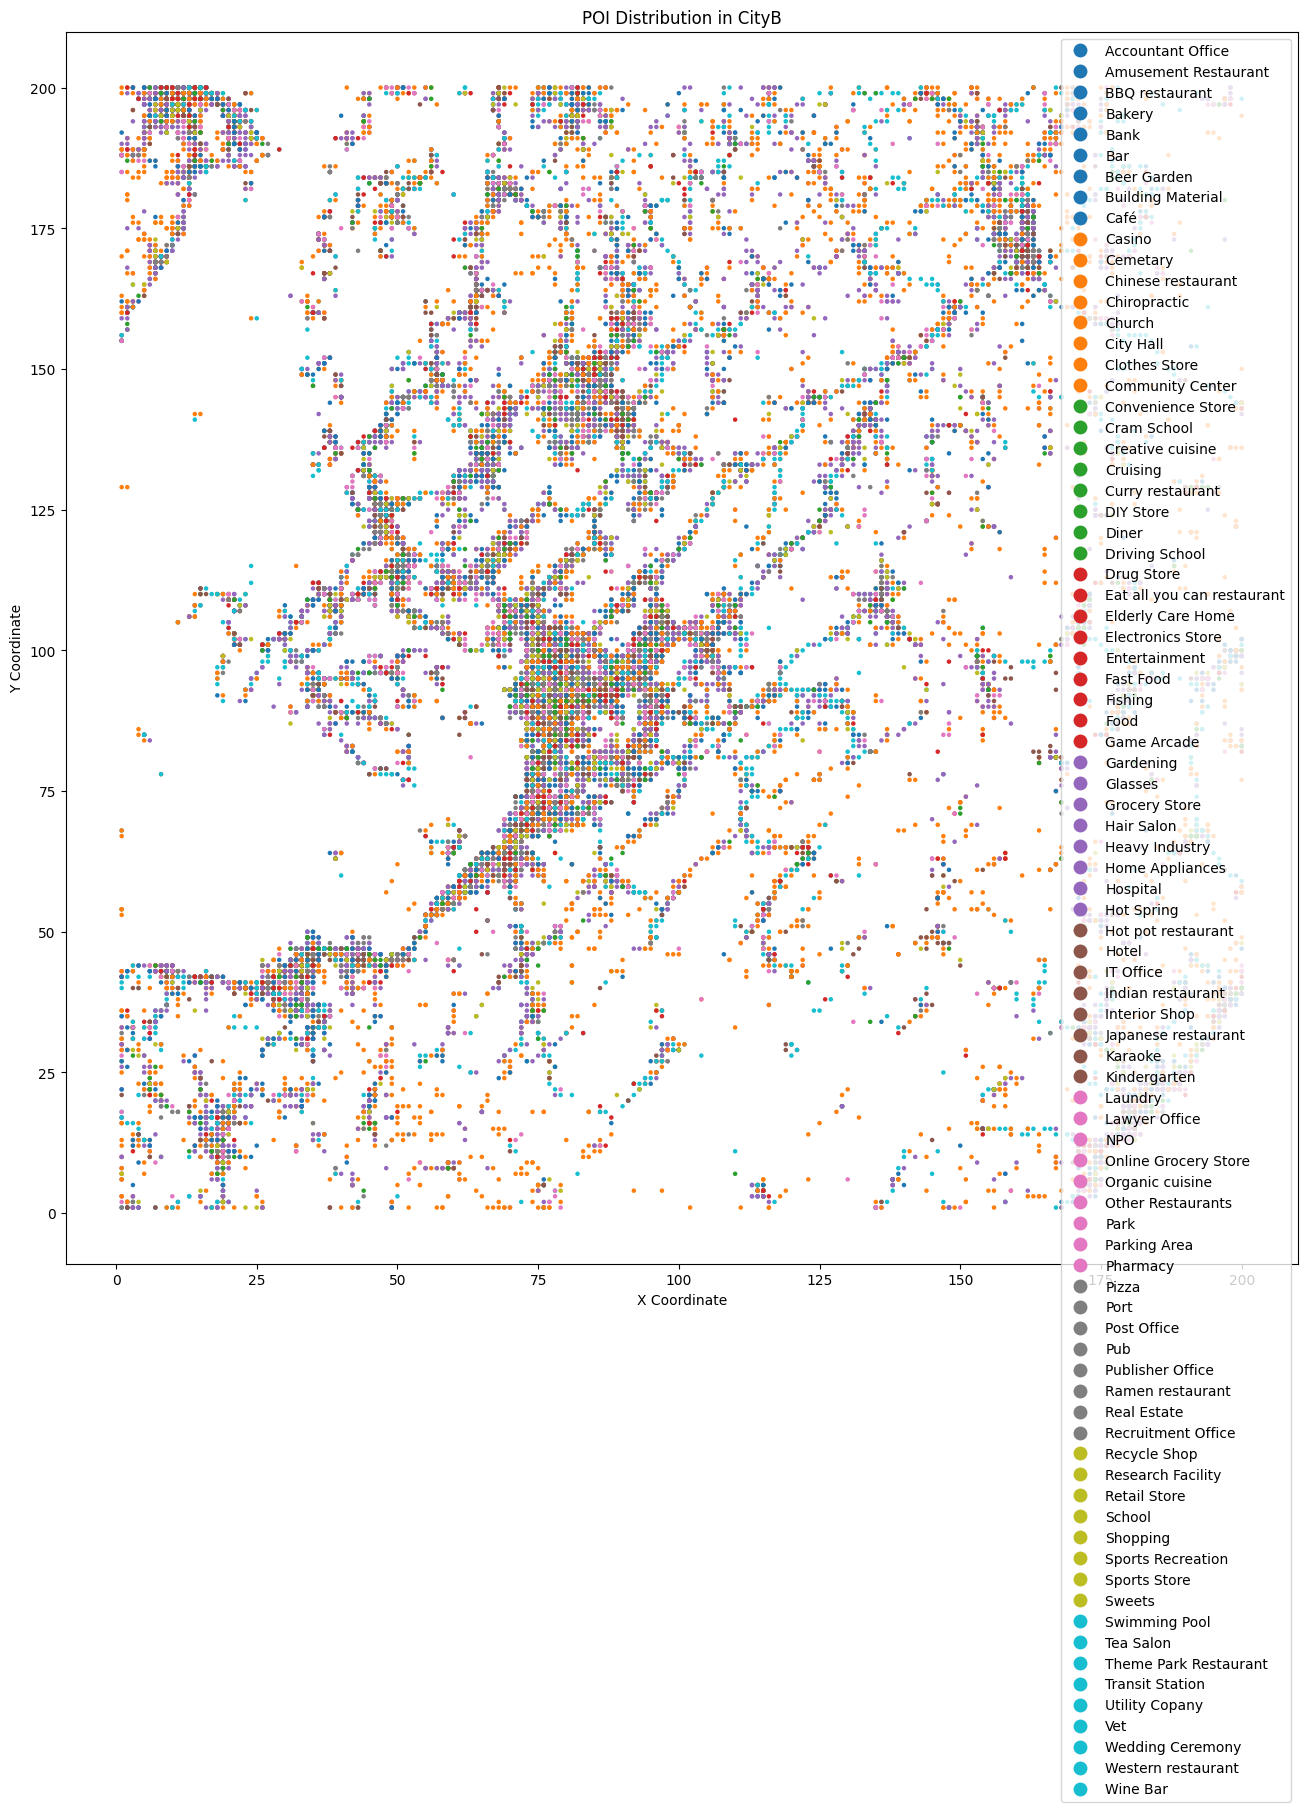

<Figure size 1000x800 with 0 Axes>

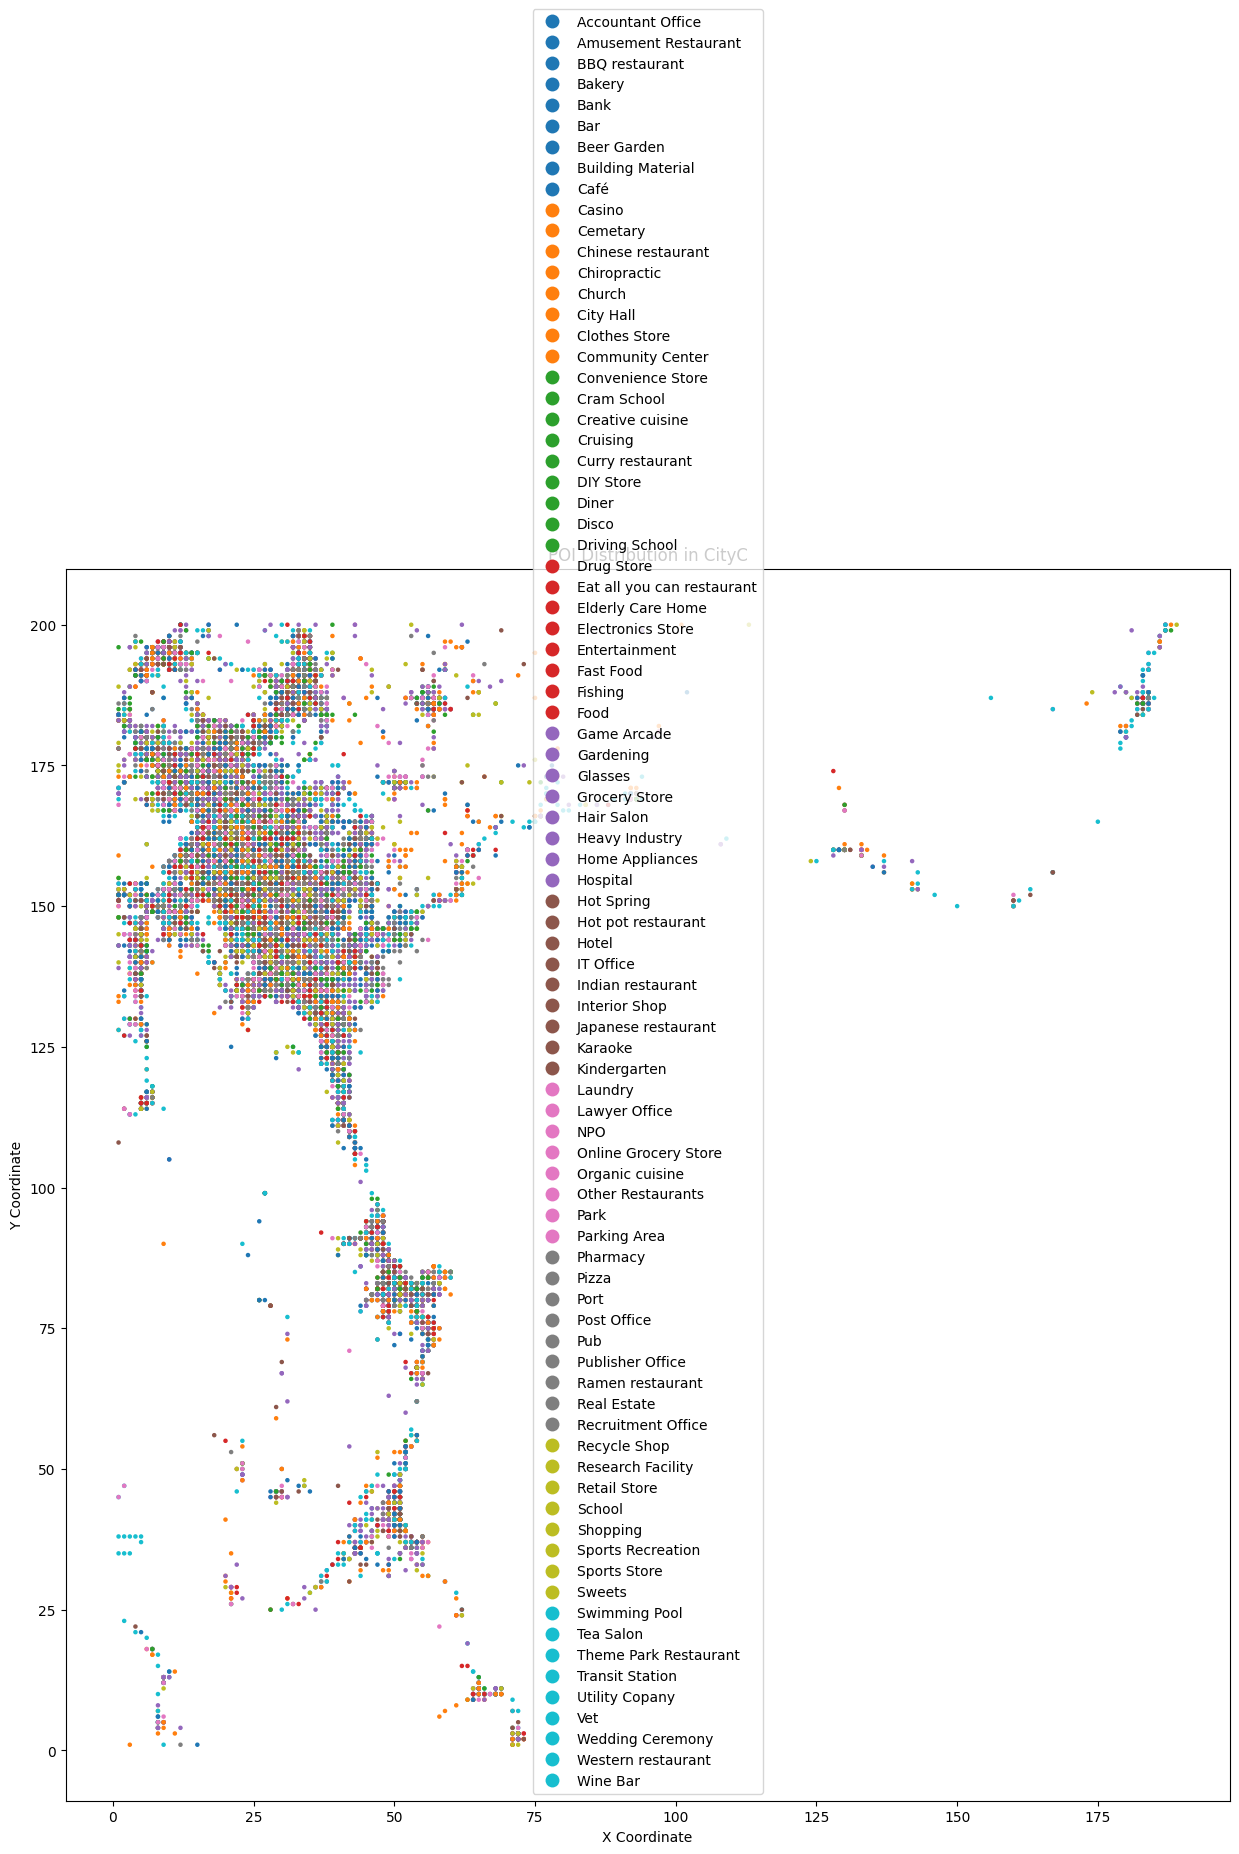

<Figure size 1000x800 with 0 Axes>

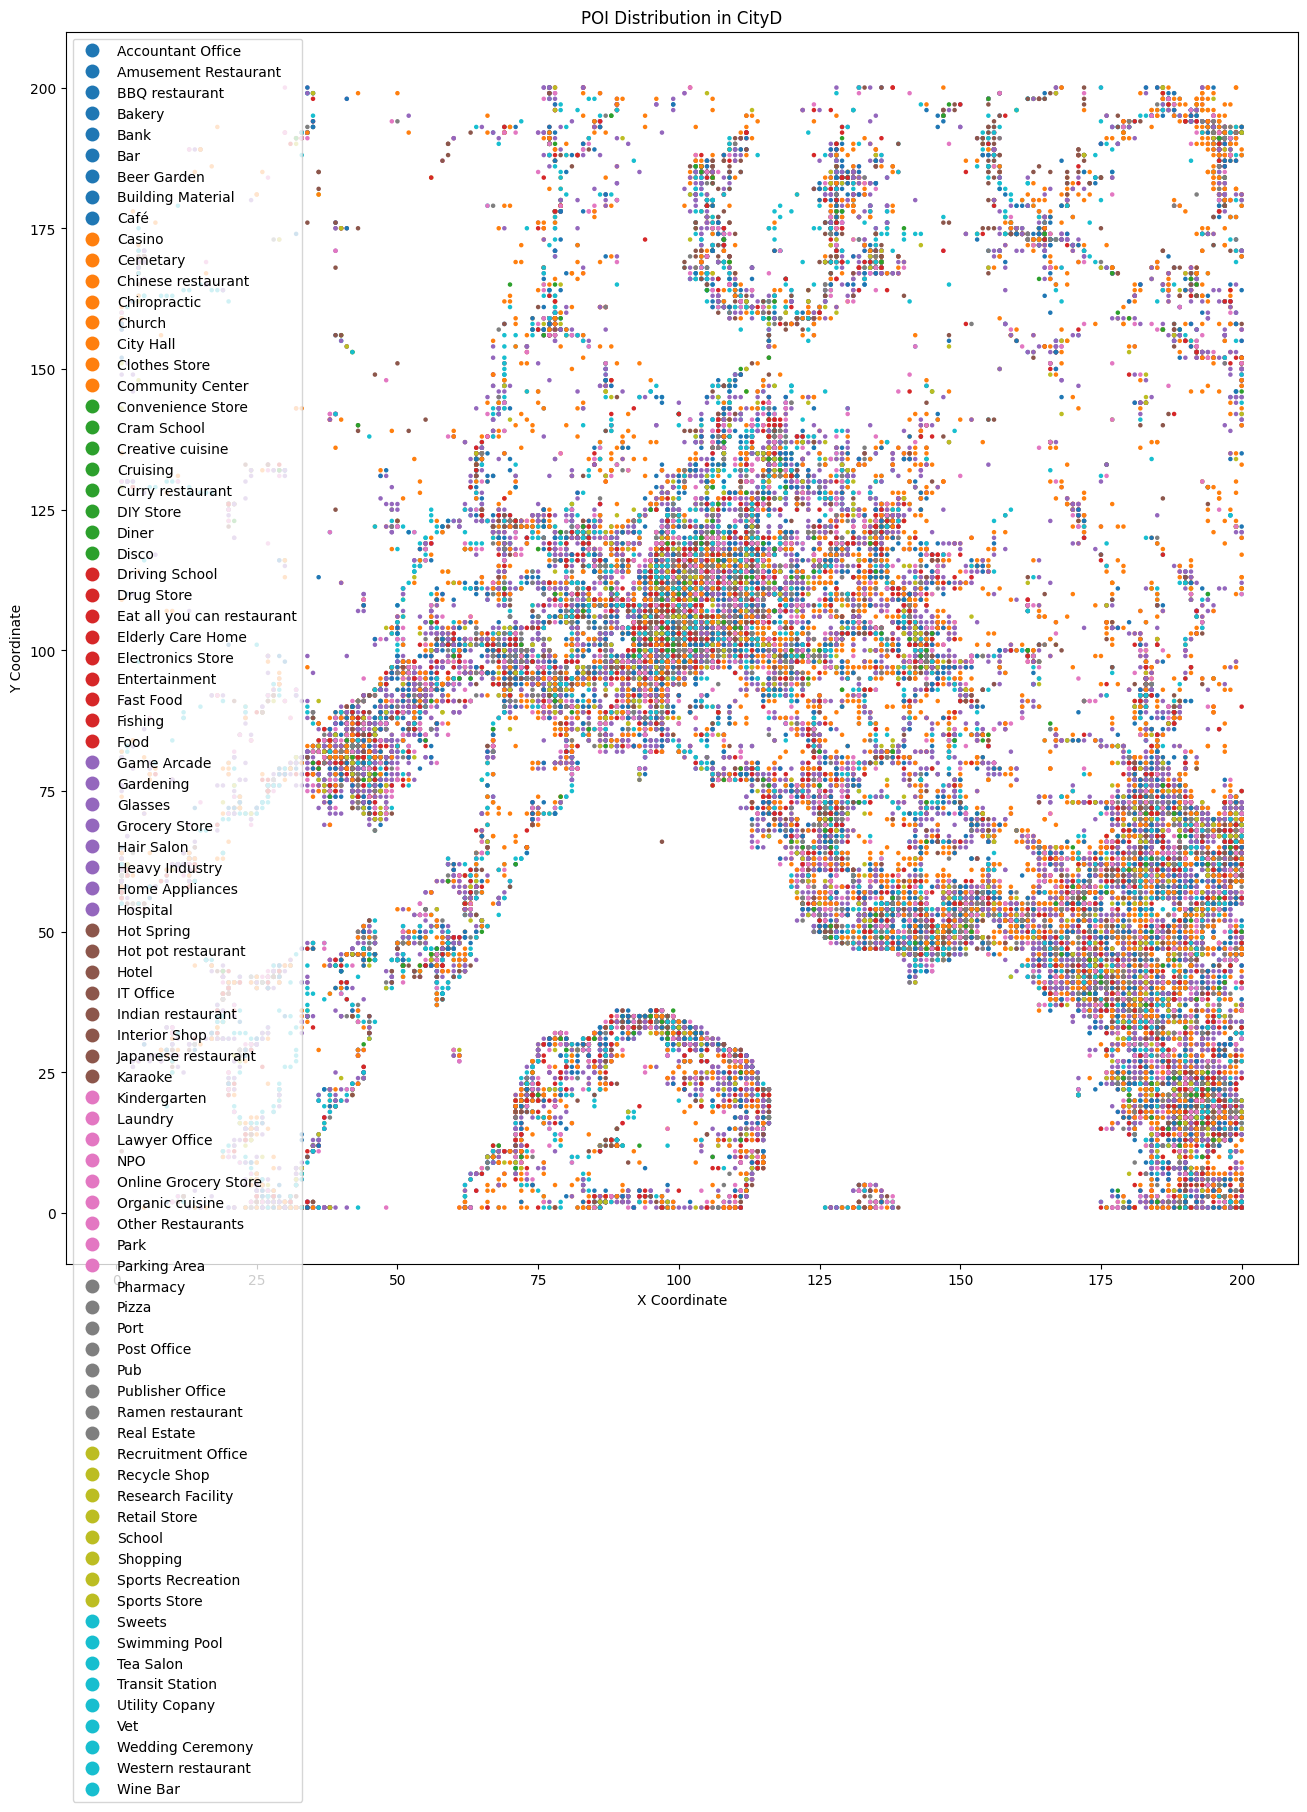

In [25]:
import matplotlib.pyplot as plt

for city, poi_gdf in poi_gdfs.items():
    plt.figure(figsize=(10, 8))
    poi_gdf.plot(column="category_name", legend=True, figsize=(20, 16), markersize=5)
    plt.title(f"POI Distribution in {city}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [26]:
# Define function for chunk processing with staypoint and tripleg generation
def process_city_in_chunks(file_path, poi_gdf, reference_date, chunk_size=50000, 
                           dist_threshold=3, time_threshold=60, gap_threshold=90):
    triplegs_list = []
    # Process data in chunks
    for chunk_idx, chunk in enumerate(pd.read_csv(file_path, usecols=['uid', 'd', 't', 'x', 'y'], chunksize=chunk_size)):
        
        # Preprocess each chunk
        chunk['x'] = chunk['x'].replace(-999, np.nan)
        chunk['y'] = chunk['y'].replace(-999, np.nan)
        chunk = chunk.dropna(subset=['x', 'y'])

        # Create tracked_at datetime by adding days and 30-minute intervals
        chunk['tracked_at'] = reference_date + \
                              chunk['d'].apply(lambda x: timedelta(days=int(x))) + \
                              chunk['t'].apply(lambda x: timedelta(minutes=int(x) * 30))
        
        # Filter data to include only the first 30 days
        chunk = chunk[chunk['tracked_at'] < (reference_date + timedelta(days=30))]
        if chunk.empty:
            print(f"Chunk {chunk_idx + 1} is empty after filtering for the first 30 days. Skipping.")
            continue
        # Convert to timezone-aware datetime in UTC
        chunk['tracked_at'] = chunk['tracked_at'].dt.tz_localize('UTC')
        chunk = chunk.rename(columns={'uid': 'user_id'})  # Only rename `uid` to `user_id`
        chunk['geometry'] = [Point(xy) for xy in zip(chunk['x'], chunk['y'])]
        chunk = gpd.GeoDataFrame(chunk, geometry='geometry' ,crs="EPSG:3857")
        # Debugging: Check chunk preprocessing
        print(f"Processing chunk {chunk_idx + 1}: {len(chunk)} entries after preprocessing.")



        # Filter out rows with invalid geometries and print debug information
        invalid_geometry_rows = chunk[chunk['geometry'].isnull()]  # Identify rows with invalid geometries
        if not invalid_geometry_rows.empty:
            print(f"Found {len(invalid_geometry_rows)} rows with invalid geometries in chunk:")
            print(invalid_geometry_rows[['user_id', 'tracked_at', 'x', 'y']])  # Print useful debug info about invalid rows
        # Keep only rows with valid geometries
        chunk = chunk[chunk['geometry'].notnull()]
        
        # Convert chunk to positionfixes
        pfs = ti.io.read_positionfixes_gpd(chunk, tracked_at='tracked_at', user_id='user_id', geom_col='geometry')
        # Generate staypoints using trackintel's generate_staypoints function
        try:
            pfs, staypoints = ti.preprocessing.positionfixes.generate_staypoints(
                pfs,
                method='sliding',
                dist_threshold=dist_threshold,
                time_threshold=time_threshold,
                gap_threshold=gap_threshold
            )
            # Debugging: Check staypoints
            print(f"Staypoints generated for chunk {chunk_idx + 1}: {len(staypoints)} entries.")

            if not staypoints.empty:
                plt.figure(figsize=(10, 8))
                staypoints.plot("geometry", color="red", alpha=0.6, markersize=10, label="Staypoints")
                plt.title(f"Staypoints for Chunk {chunk_idx + 1}")
                plt.legend()
                plt.show()





            if staypoints.empty:
                print(f"No staypoints generated in chunk {chunk_idx + 1}. Skipping.")
                continue
        except Exception as e:
            print(f"Error generating staypoints in chunk {chunk_idx + 1}: {e}")
            continue
        try:
            pfs, triplegs_chunk = ti.preprocessing.positionfixes.generate_triplegs(
                pfs,
                staypoints=staypoints,
                method='between_staypoints',
                gap_threshold=gap_threshold
            )
            if triplegs_chunk.empty:
                print(f"No triplegs generated in chunk {chunk_idx + 1}. Skipping.")
                continue
        except Exception as e:
            print(f"Error generating triplegs in chunk {chunk_idx + 1}: {e}")
            continue
                    # Print the columns of triplegs_chunk to verify column names
        # Debugging: Validate triplegs_chunk
        print(f"Triplegs generated for chunk {chunk_idx + 1}: {len(triplegs_chunk)} entries.")
        if not triplegs_chunk.empty:
            plt.figure(figsize=(10, 8))
            triplegs_chunk.plot("geom", color="blue", alpha=0.6, label="Triplegs")
            plt.title(f"Triplegs for Chunk {chunk_idx + 1}")
            plt.legend()
            plt.show()
        # Associate triplegs with nearest POIs
        try:
            if 'geom' not in triplegs_chunk.columns or triplegs_chunk['geom'].isnull().any():
                print(f"Skipping POI matching in chunk {chunk_idx + 1} due to missing or invalid geometry.")
                continue
            triplegs_chunk['nearest_poi'] = triplegs_chunk.apply(
                lambda row: poi_gdf.loc[poi_gdf.distance(row['geom']).idxmin(), 'category_name'], axis=1
            )
        except Exception as e:
            print(f"Error associating POIs in chunk {chunk_idx + 1}: {e}")
            continue
        
        # Debugging: Display triplegs after POI matching
        print(f"Triplegs with POI matching for chunk {chunk_idx + 1}:")
        print(triplegs_chunk.head())
        # Append triplegs to the result
        triplegs_list.append(triplegs_chunk)
        # Concatenate all triplegs from chunks
        triplegs_all = pd.concat(triplegs_list, ignore_index=True)
        return triplegs_all



Processing chunk 1: 19306 entries after preprocessing.
Staypoints generated for chunk 1: 3457 entries.


C:\Users\lingyi\AppData\Local\Temp\ipykernel_23940\2066782580.py:57: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  staypoints.plot("geometry", color="red", alpha=0.6, markersize=10, label="Staypoints")


<Figure size 1000x800 with 0 Axes>

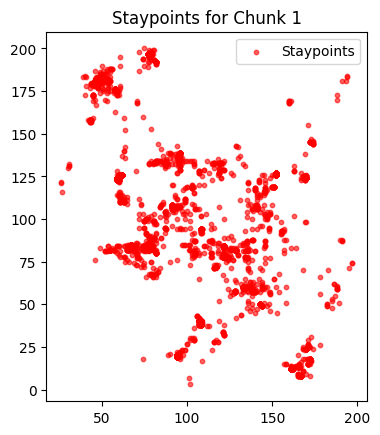

d:\lingyi\Documents\4032 data\4032-data\.venv\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()


Triplegs generated for chunk 1: 2549 entries.


d:\lingyi\Documents\4032 data\4032-data\.venv\Lib\site-packages\trackintel\preprocessing\positionfixes.py:573: UserWarning: The positionfixes with ids [    0     1     2     3   160   161   164   165  1327  1328  1329  1364
  1365  1510  1511  1608  1609  1610  1830  1831  2065  2066  2067  4044
  4045  4046  4047  4061  4062  4099  4100  4224  4225  5156  5157  5403
  5404  6210  6211  6586  6587  6718  6719  6720  6721  6775  6776  6777
  6778  6818  6819  6919  6920  8265  8266  9186  9187  9431  9432 11518
 11519 11636 11637 11933 11934 11935 11936 11937 11938 12577 12578 12579
 12601 12602 12623 12624 12625 12720 12721 12722 12723 12742 12743 12744
 12766 12767 12768 12816 12817 12818 12819 12820 12821 12838 12839 12840
 12841 12842 12843 12844 12845 12846 12861 12862 12863 12864 12865 12898
 12899 12945 12946 12947 12962 12963 12964 12966 12967 12994 12995 13043
 13044 13065 13066 13067 13068 13110 13111 13147 13148 13149 13150 13151
 13152 13153 13184 13185 13271 13272 13273 132

<Figure size 1000x800 with 0 Axes>

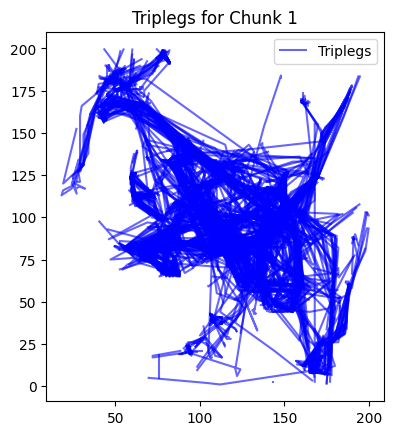

Triplegs with POI matching for chunk 1:
    user_id                started_at               finished_at  \
id                                                                
2         0 2023-01-01 09:30:00+00:00 2023-01-01 10:00:00+00:00   
3         0 2023-01-01 14:30:00+00:00 2023-01-01 15:00:00+00:00   
4         0 2023-01-02 09:30:00+00:00 2023-01-02 12:00:00+00:00   
5         0 2023-01-03 06:00:00+00:00 2023-01-03 06:30:00+00:00   
6         0 2023-01-03 08:30:00+00:00 2023-01-03 11:30:00+00:00   

                                                 geom      nearest_poi  
id                                                                      
2           LINESTRING (81.000 89.000, 82.000 88.000)   Heavy Industry  
3           LINESTRING (76.000 83.000, 77.000 86.000)      Real Estate  
4   LINESTRING (76.000 85.000, 75.000 85.000, 77.0...   Heavy Industry  
5           LINESTRING (84.000 89.000, 89.000 78.000)      Real Estate  
6   LINESTRING (116.000 79.000, 110.000 87.000, 11..

C:\Users\lingyi\AppData\Local\Temp\ipykernel_23940\2066782580.py:57: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  staypoints.plot("geometry", color="red", alpha=0.6, markersize=10, label="Staypoints")


<Figure size 1000x800 with 0 Axes>

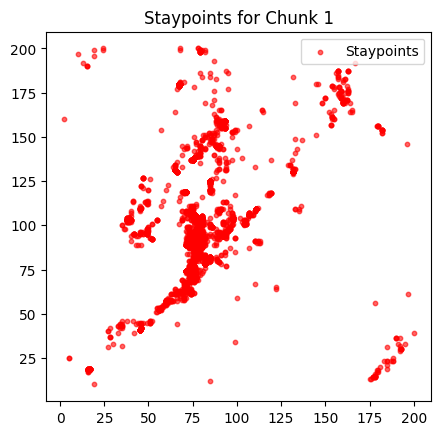

Triplegs generated for chunk 1: 2800 entries.


d:\lingyi\Documents\4032 data\4032-data\.venv\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
d:\lingyi\Documents\4032 data\4032-data\.venv\Lib\site-packages\trackintel\preprocessing\positionfixes.py:573: UserWarning: The positionfixes with ids [   14    15   168   169   256   257   258   259   260   335   336   455
   456  1578  1579  1629  1630  1658  1659  1677  1678  1679  1716  1717
  1736  1737  1881  1882  1890  1891  1892  1893  1894  1935  1936  1955
  1956  1957  1958  1996  1997  2007  2008  2071  2072  2073  2096  2097
  2973  2974  3020  3021  3070  3071  3072  3073  3074  3108  3109  3110
  3166  3167  3168  3169  3170  3200  3201  3209  3210  3248 

<Figure size 1000x800 with 0 Axes>

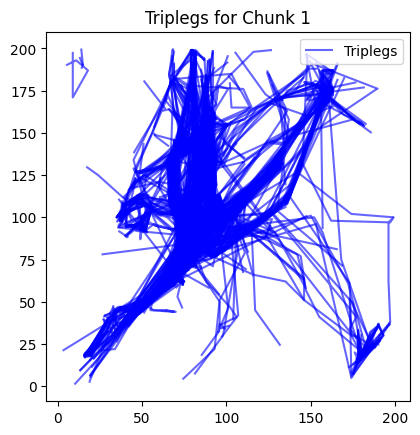

Triplegs with POI matching for chunk 1:
    user_id                started_at               finished_at  \
id                                                                
0         0 2023-01-01 10:00:00+00:00 2023-01-01 10:30:00+00:00   
1         0 2023-01-01 12:30:00+00:00 2023-01-01 13:30:00+00:00   
2         0 2023-01-01 19:00:00+00:00 2023-01-01 19:30:00+00:00   
3         0 2023-01-01 21:30:00+00:00 2023-01-01 22:00:00+00:00   
5         0 2023-01-03 13:00:00+00:00 2023-01-03 14:00:00+00:00   

                                                 geom      nearest_poi  
id                                                                      
0           LINESTRING (80.000 99.000, 81.000 97.000)      Real Estate  
1   LINESTRING (83.000 102.000, 80.000 101.000, 80...      Real Estate  
2          LINESTRING (80.000 102.000, 79.000 96.000)  Transit Station  
3          LINESTRING (80.000 97.000, 80.000 101.000)      Real Estate  
5   LINESTRING (90.000 109.000, 90.000 108.000, 90..

C:\Users\lingyi\AppData\Local\Temp\ipykernel_23940\2066782580.py:57: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  staypoints.plot("geometry", color="red", alpha=0.6, markersize=10, label="Staypoints")


<Figure size 1000x800 with 0 Axes>

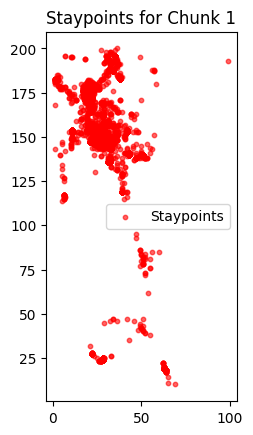

d:\lingyi\Documents\4032 data\4032-data\.venv\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()


Triplegs generated for chunk 1: 2420 entries.


d:\lingyi\Documents\4032 data\4032-data\.venv\Lib\site-packages\trackintel\preprocessing\positionfixes.py:573: UserWarning: The positionfixes with ids [   38    39    40 ... 47813 48708 48709] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)
C:\Users\lingyi\AppData\Local\Temp\ipykernel_23940\2066782580.py:90: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  triplegs_chunk.plot("geom", color="blue", alpha=0.6, label="Triplegs")


<Figure size 1000x800 with 0 Axes>

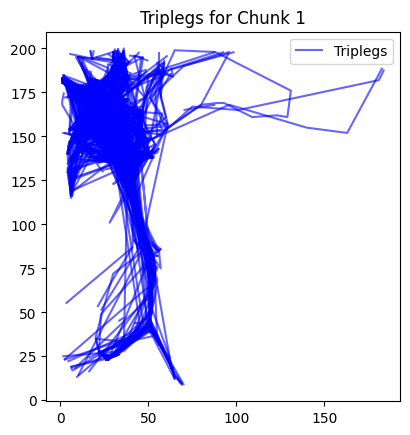

Triplegs with POI matching for chunk 1:
    user_id                started_at               finished_at  \
id                                                                
0         0 2023-01-06 07:30:00+00:00 2023-01-06 12:30:00+00:00   
1         0 2023-01-06 14:30:00+00:00 2023-01-06 16:00:00+00:00   
2         0 2023-01-06 19:00:00+00:00 2023-01-06 19:30:00+00:00   
3         0 2023-01-07 00:00:00+00:00 2023-01-07 01:00:00+00:00   
4         0 2023-01-07 07:30:00+00:00 2023-01-07 08:00:00+00:00   

                                                 geom    nearest_poi  
id                                                                    
0   LINESTRING (28.000 157.000, 28.000 158.000, 28...    Real Estate  
1   LINESTRING (29.000 158.000, 28.000 157.000, 29...    Real Estate  
2         LINESTRING (28.000 157.000, 29.000 158.000)    Real Estate  
3   LINESTRING (28.000 158.000, 28.000 157.000, 28...    Real Estate  
4         LINESTRING (29.000 158.000, 27.000 157.000)  Clothes S

C:\Users\lingyi\AppData\Local\Temp\ipykernel_23940\2066782580.py:57: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  staypoints.plot("geometry", color="red", alpha=0.6, markersize=10, label="Staypoints")


<Figure size 1000x800 with 0 Axes>

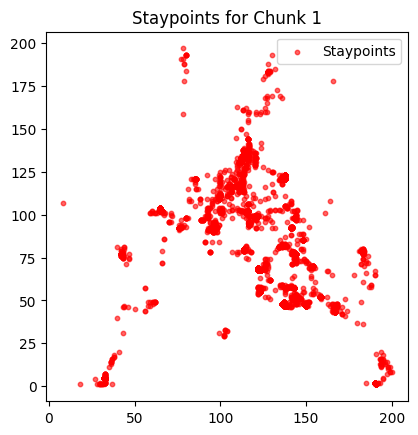

d:\lingyi\Documents\4032 data\4032-data\.venv\Lib\site-packages\trackintel\preprocessing\positionfixes.py:361: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pfs["tripleg_id"] = pfs["tripleg_id"].ffill()
d:\lingyi\Documents\4032 data\4032-data\.venv\Lib\site-packages\trackintel\preprocessing\positionfixes.py:573: UserWarning: The positionfixes with ids [ 1814  1815  1816  1889  1890  1919  1920  2089  2090  2138  2139  2140
  2141  2206  2207  2217  2218  2264  2265  2347  2348  2368  2369  3291
  3292  3293  3602  3603  3815  3816  4707  4708  4709  4823  4824  4843
  4844  4905  4906  4907  4959  4960  5311  5312  6478  6479  6480  6489
  6490  8381  8382  8528  8529  8554  8555  8556  9873  9874  9922  9923
  9924 10578 10579 10611 10612 10613 10787 10788 10881 10882 

Triplegs generated for chunk 1: 2575 entries.


<Figure size 1000x800 with 0 Axes>

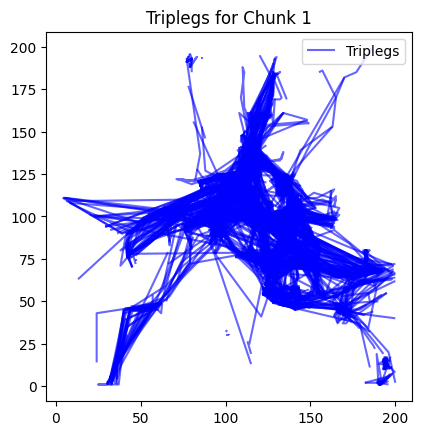

Triplegs with POI matching for chunk 1:
    user_id                started_at               finished_at  \
id                                                                
0         0 2023-01-01 08:00:00+00:00 2023-01-01 08:30:00+00:00   
1         0 2023-01-01 10:00:00+00:00 2023-01-01 11:30:00+00:00   
2         0 2023-01-01 13:00:00+00:00 2023-01-01 14:00:00+00:00   
3         0 2023-01-01 16:30:00+00:00 2023-01-01 19:30:00+00:00   
4         0 2023-01-01 21:00:00+00:00 2023-01-01 22:00:00+00:00   

                                                 geom          nearest_poi  
id                                                                          
0         LINESTRING (162.000 99.000, 149.000 97.000)  Japanese restaurant  
1   LINESTRING (160.000 100.000, 155.000 99.000, 1...                  Pub  
2   LINESTRING (144.000 97.000, 144.000 99.000, 15...             Laundry   
3   LINESTRING (153.000 99.000, 164.000 93.000, 14...                  Pub  
4   LINESTRING (120.000 103.

In [27]:
# Process each city file in chunks
triplegs_dict = {
    city: process_city_in_chunks(path, poi_gdfs[city], reference_date) 
    for city, path in file_paths.items()
}

In [28]:
print(len(triplegs_dict))

4


In [29]:
print(triplegs_dict)

{'CityA':       user_id                started_at               finished_at  \
0           0 2023-01-01 09:30:00+00:00 2023-01-01 10:00:00+00:00   
1           0 2023-01-01 14:30:00+00:00 2023-01-01 15:00:00+00:00   
2           0 2023-01-02 09:30:00+00:00 2023-01-02 12:00:00+00:00   
3           0 2023-01-03 06:00:00+00:00 2023-01-03 06:30:00+00:00   
4           0 2023-01-03 08:30:00+00:00 2023-01-03 11:30:00+00:00   
...       ...                       ...                       ...   
2544       33 2023-01-29 16:30:00+00:00 2023-01-29 18:00:00+00:00   
2545       33 2023-01-30 03:30:00+00:00 2023-01-30 04:30:00+00:00   
2546       33 2023-01-30 08:00:00+00:00 2023-01-30 09:00:00+00:00   
2547       33 2023-01-30 13:30:00+00:00 2023-01-30 15:00:00+00:00   
2548       33 2023-01-30 17:00:00+00:00 2023-01-30 21:00:00+00:00   

                                                   geom          nearest_poi  
0             LINESTRING (81.000 89.000, 82.000 88.000)       Heavy Industry  
1  

In [30]:
print(triplegs_dict.items())

dict_items([('CityA',       user_id                started_at               finished_at  \
0           0 2023-01-01 09:30:00+00:00 2023-01-01 10:00:00+00:00   
1           0 2023-01-01 14:30:00+00:00 2023-01-01 15:00:00+00:00   
2           0 2023-01-02 09:30:00+00:00 2023-01-02 12:00:00+00:00   
3           0 2023-01-03 06:00:00+00:00 2023-01-03 06:30:00+00:00   
4           0 2023-01-03 08:30:00+00:00 2023-01-03 11:30:00+00:00   
...       ...                       ...                       ...   
2544       33 2023-01-29 16:30:00+00:00 2023-01-29 18:00:00+00:00   
2545       33 2023-01-30 03:30:00+00:00 2023-01-30 04:30:00+00:00   
2546       33 2023-01-30 08:00:00+00:00 2023-01-30 09:00:00+00:00   
2547       33 2023-01-30 13:30:00+00:00 2023-01-30 15:00:00+00:00   
2548       33 2023-01-30 17:00:00+00:00 2023-01-30 21:00:00+00:00   

                                                   geom          nearest_poi  
0             LINESTRING (81.000 89.000, 82.000 88.000)       Heavy In

In [31]:

import pandas as pd
from shapely.geometry import LineString

def extract_tripleg_sequences(triplegs_df):
    """
    Extract sequences from triplegs for sequential pattern mining.
    """
    sequences = []
    for idx, tripleg in triplegs_df.iterrows():
        # Extract coordinates from LineString
        if isinstance(tripleg['geom'], LineString):
            coords = list(tripleg['geom'].coords)
            sequences.append(coords)
    return sequences

# Assuming triplegs_dict contains triplegs for multiple cities
all_sequences = {}
for city, triplegs_df in triplegs_dict.items():
    print(f"Extracting sequences for city: {city}")
    sequences = extract_tripleg_sequences(triplegs_df)
    all_sequences[city] = sequences



Extracting sequences for city: CityA
Extracting sequences for city: CityB
Extracting sequences for city: CityC
Extracting sequences for city: CityD


In [41]:
from collections import defaultdict

def enhanced_gsp(sequences, min_support=0.1, max_pattern_length=3):
    """
    Generalized Sequential Pattern (GSP) Algorithm with enhancements.
    Args:
        sequences: List of sequences (e.g., [[(x1, y1), (x2, y2)], ...]).
        min_support: Minimum support threshold (proportion).
        max_pattern_length: Maximum length of sequential patterns to consider.
    Returns:
        frequent_patterns: A dictionary of patterns with their support counts.
    """
    # Initialize variables
    support_count = defaultdict(int)
    total_sequences = len(sequences)
    min_count = int(min_support * total_sequences)

    # Generate 1-sequence candidates
    candidates = set()
    for seq in sequences:
        for elem in seq:
            candidates.add((elem,))  # Use tuples to maintain order

    # Iteratively find frequent k-sequences
    frequent_patterns = {}
    pattern_length = 1

    while candidates and pattern_length <= max_pattern_length:
        # Count candidate occurrences
        candidate_support = defaultdict(int)
        for candidate in candidates:
            for seq in sequences:
                if all(elem in seq for elem in candidate):
                    candidate_support[candidate] += 1

        # Filter frequent patterns
        candidates = {c for c, count in candidate_support.items() if count >= min_count}
        frequent_patterns.update({c: count for c, count in candidate_support.items() if count >= min_count})

        # Generate k+1 candidates from frequent k-patterns
        pattern_length += 1
        candidates = {
            tuple(list(c1) + [c2[-1]]) for c1 in candidates for c2 in candidates
            if c1[1:] == c2[:-1]  # Ensure the patterns overlap sequentially
        }

    return frequent_patterns


In [43]:
# Run GSP for CityA
frequent_patterns = enhanced_gsp(all_sequences['CityA'], min_support=0.01, max_pattern_length=3)
print(f"Frequent patterns with support counts: {frequent_patterns}")



Frequent patterns with support counts: {((60.0, 126.0),): 52, ((88.0, 132.0),): 33, ((76.0, 83.0),): 40, ((128.0, 58.0),): 28, ((45.0, 179.0),): 51, ((92.0, 106.0),): 30, ((170.0, 124.0),): 62, ((108.0, 38.0),): 35, ((78.0, 197.0),): 47, ((141.0, 107.0),): 29, ((60.0, 114.0),): 31, ((77.0, 82.0),): 42, ((47.0, 182.0),): 45, ((96.0, 139.0),): 30, ((143.0, 50.0),): 31, ((79.0, 196.0),): 29, ((140.0, 117.0),): 25, ((167.0, 8.0),): 34, ((77.0, 197.0),): 59, ((117.0, 72.0),): 29, ((59.0, 124.0),): 65, ((67.0, 85.0),): 48, ((138.0, 58.0),): 30, ((122.0, 84.0),): 36, ((94.0, 20.0),): 41, ((105.0, 80.0),): 26, ((124.0, 78.0),): 28, ((79.0, 198.0),): 30, ((44.0, 158.0),): 25, ((107.0, 40.0),): 42, ((108.0, 94.0),): 27, ((55.0, 82.0),): 41, ((88.0, 133.0),): 29, ((108.0, 40.0),): 60, ((77.0, 86.0),): 29, ((119.0, 127.0),): 27, ((45.0, 180.0),): 46, ((59.0, 123.0),): 25, ((108.0, 39.0),): 32, ((67.0, 84.0),): 48, ((66.0, 82.0),): 25, ((122.0, 83.0),): 30, ((95.0, 20.0),): 32, ((48.0, 182.0),): 32

In [45]:
# Generate frequent patterns for all cities
frequent_patterns_all_cities = {}

for city, sequences in all_sequences.items():
    print(f"Running GSP for city: {city}")
    frequent_patterns = enhanced_gsp(sequences, min_support=0.01, max_pattern_length=3)
    frequent_patterns_all_cities[city] = frequent_patterns
    print(f"Frequent patterns for {city}: {frequent_patterns}")


Running GSP for city: CityA
Frequent patterns for CityA: {((60.0, 126.0),): 52, ((88.0, 132.0),): 33, ((76.0, 83.0),): 40, ((128.0, 58.0),): 28, ((45.0, 179.0),): 51, ((92.0, 106.0),): 30, ((170.0, 124.0),): 62, ((108.0, 38.0),): 35, ((78.0, 197.0),): 47, ((141.0, 107.0),): 29, ((60.0, 114.0),): 31, ((77.0, 82.0),): 42, ((47.0, 182.0),): 45, ((96.0, 139.0),): 30, ((143.0, 50.0),): 31, ((79.0, 196.0),): 29, ((140.0, 117.0),): 25, ((167.0, 8.0),): 34, ((77.0, 197.0),): 59, ((117.0, 72.0),): 29, ((59.0, 124.0),): 65, ((67.0, 85.0),): 48, ((138.0, 58.0),): 30, ((122.0, 84.0),): 36, ((94.0, 20.0),): 41, ((105.0, 80.0),): 26, ((124.0, 78.0),): 28, ((79.0, 198.0),): 30, ((44.0, 158.0),): 25, ((107.0, 40.0),): 42, ((108.0, 94.0),): 27, ((55.0, 82.0),): 41, ((88.0, 133.0),): 29, ((108.0, 40.0),): 60, ((77.0, 86.0),): 29, ((119.0, 127.0),): 27, ((45.0, 180.0),): 46, ((59.0, 123.0),): 25, ((108.0, 39.0),): 32, ((67.0, 84.0),): 48, ((66.0, 82.0),): 25, ((122.0, 83.0),): 30, ((95.0, 20.0),): 32, ((

In [47]:
# Create a mapping of coordinates to POI names or categories
poi_mapping = {
    (row.geometry.x, row.geometry.y): row.category_name
    for _, row in poi_gdfs['CityA'].iterrows()  # Replace 'CityA' with the desired city
}


In [51]:
def map_coordinates_to_pois(frequent_patterns, poi_mapping):
    """
    Map coordinate patterns to their corresponding POI names or categories.
    This function preserves the sequence structure of patterns.
    """
    transformed_patterns = {}
    for pattern, count in frequent_patterns.items():
        try:
            # Map each coordinate in the sequence to a POI name or category
            mapped_pattern = tuple(
                poi_mapping.get((coord[0], coord[1]), "Unknown") for coord in pattern
            )
            transformed_patterns[mapped_pattern] = count
        except Exception as e:
            print(f"Error mapping pattern {pattern}: {e}")
    return transformed_patterns

# Transform patterns for CityA
poi_patterns = map_coordinates_to_pois(frequent_patterns, poi_mapping)

# Display the transformed patterns
for pattern, count in poi_patterns.items():
    print(f"Pattern: {pattern}, Count: {count}")




Pattern: ('Bank',), Count: 45
Pattern: ('Pharmacy',), Count: 33
Pattern: ('Convenience Store',), Count: 40
Pattern: ('Chiropractic',), Count: 29
Pattern: ('Sweets ',), Count: 51
Pattern: ('Unknown',), Count: 59
Pattern: ('Church',), Count: 34
Pattern: ('Japanese restaurant',), Count: 35
Pattern: ('Heavy Industry',), Count: 47
Pattern: ('Accountant Office',), Count: 29
Pattern: ('Lawyer Office',), Count: 32
Pattern: ('BBQ restaurant',), Count: 42
Pattern: ('Park',), Count: 30
Pattern: ('Clothes Store',), Count: 31
Pattern: ('Driving School',), Count: 32
Pattern: ('Retail Store',), Count: 65
Pattern: ('Hair Salon',), Count: 48
Pattern: ('School',), Count: 36
Pattern: ('Fishing',), Count: 41
Pattern: ('Publisher Office',), Count: 28
Pattern: ('Port',), Count: 25
Pattern: ('Elderly Care Home',), Count: 25
Pattern: ('Building Material',), Count: 48
Pattern: ('Gardening',), Count: 60
Pattern: ('Transit Station',), Count: 25
Pattern: ('Tea Salon',), Count: 30
Pattern: ('Laundry ',), Count: 32

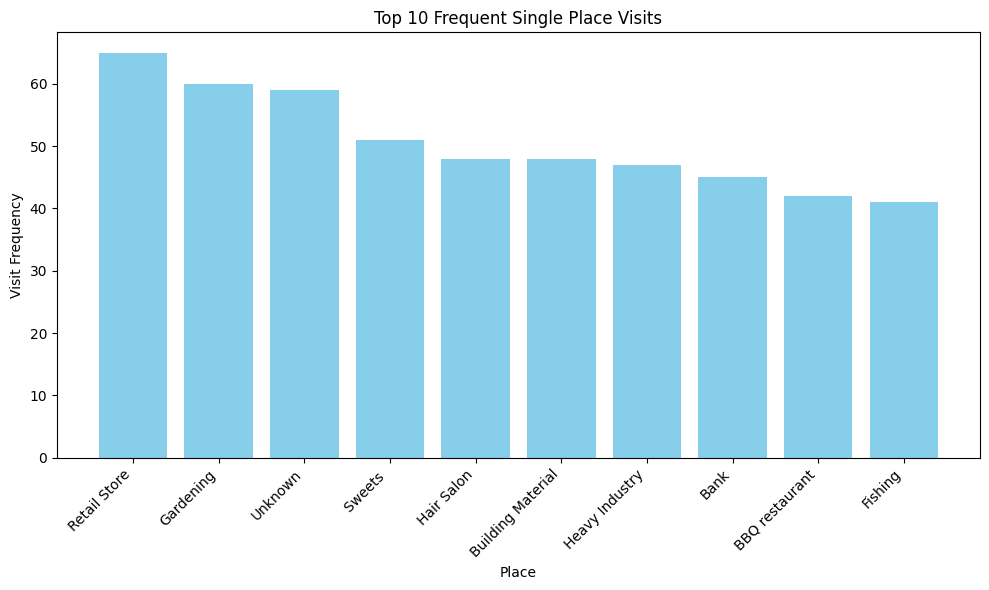

In [55]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_single_place_patterns(poi_patterns):
    """
    Visualize the most frequent single-place visits.
    """
    # Filter patterns with only one place
    single_place_patterns = {pattern: count for pattern, count in poi_patterns.items() if len(pattern) == 1}
    
    # Sort by frequency
    sorted_single_patterns = sorted(single_place_patterns.items(), key=lambda x: x[1], reverse=True)
    
    # Extract data for plotting
    places = [pattern[0] for pattern, count in sorted_single_patterns]
    counts = [count for pattern, count in sorted_single_patterns]

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(places[:10], counts[:10], color='skyblue')  # Limit to top 10 for clarity
    plt.xlabel('Place')
    plt.ylabel('Visit Frequency')
    plt.title('Top 10 Frequent Single Place Visits')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Call the functions with your data
visualize_single_place_patterns(poi_patterns)



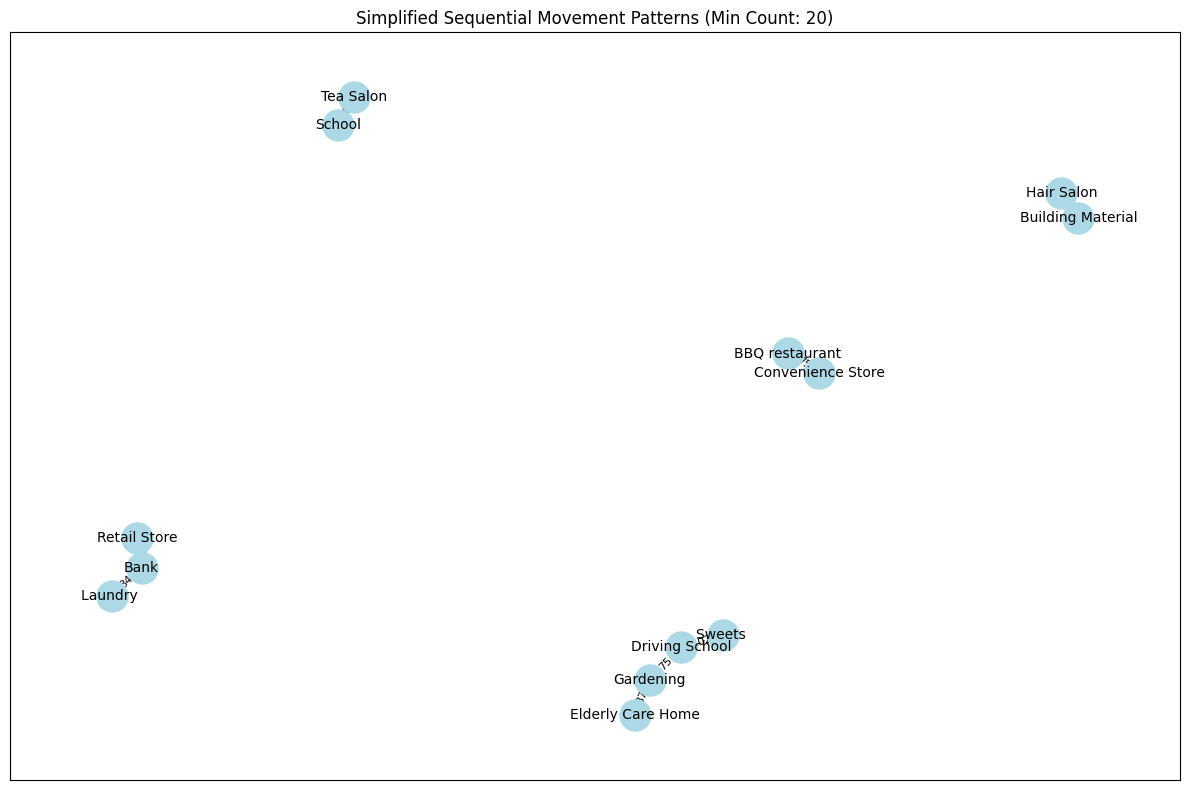

In [57]:
def visualize_simplified_sequential_patterns(poi_patterns, min_count=10):
    """
    Visualize the simplified sequential movements as a directed graph, 
    eliminating repeated places within a single pattern.

    Args:
        poi_patterns (dict): Dictionary of patterns and their frequencies.
        min_count (int): Minimum frequency for a pattern to be included in the graph.
    """
    # Filter patterns with more than one place and frequency above threshold
    sequential_patterns = {
        pattern: count
        for pattern, count in poi_patterns.items()
        if len(pattern) > 1 and count >= min_count
    }

    # Remove consecutive duplicate places from patterns
    simplified_patterns = {}
    for pattern, count in sequential_patterns.items():
        simplified_pattern = tuple(place for i, place in enumerate(pattern) if i == 0 or place != pattern[i - 1])
        if len(simplified_pattern) > 1:
            simplified_patterns[simplified_pattern] = count

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges for each simplified pattern
    for pattern, count in simplified_patterns.items():
        for i in range(len(pattern) - 1):
            if G.has_edge(pattern[i], pattern[i + 1]):
                G[pattern[i]][pattern[i + 1]]['weight'] += count
            else:
                G.add_edge(pattern[i], pattern[i + 1], weight=count)

    # Extract edge weights for visualization
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # Position nodes for better visibility
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
    nx.draw_networkx_edges(
        G,
        pos,
        width=[w / max(edge_weights) * 5 for w in edge_weights],  # Scale edge widths
        alpha=0.7,
        edge_color='gray',
    )
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # Display edge labels for weights
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f'Simplified Sequential Movement Patterns (Min Count: {min_count})')
    plt.tight_layout()
    plt.show()


# Call the function with your data and a frequency threshold
visualize_simplified_sequential_patterns(poi_patterns, min_count=20)


DBSCAN Clustering (Clustering Coordinates)
Purpose:
To group coordinates into clusters based on spatial proximity and identify noise points (coordinates that do not belong to any cluster).
This step focuses on the spatial structure of the data, grouping similar locations.
How it Works:
DBSCAN groups coordinates that are within a specified distance (eps) of each other.
Points that are not close enough to any cluster are labeled as noise.


What It Shows:
A spatial distribution of clusters:
Clusters: Points that belong to the same cluster are plotted in the same color.
Noise Points: Shown as gray dots to indicate outliers.
Gives a visual summary of spatial groupings and areas where clustering was less successful (noise).

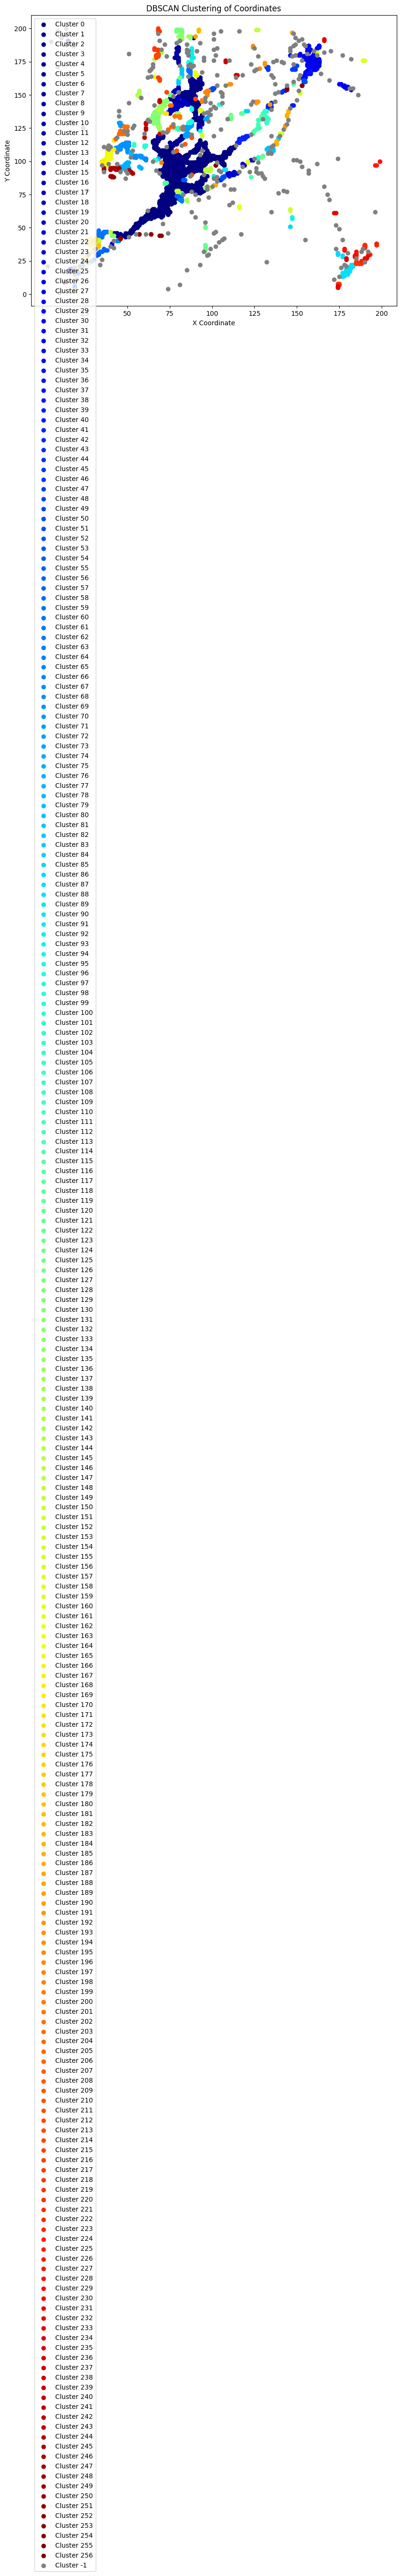

In [37]:
unique_labels = set(cluster_labels)
plt.figure(figsize=(10, 8))
for label in unique_labels:
    if label == -1:
        color = 'gray'  # Noise
    else:
        color = plt.cm.jet(float(label) / max(unique_labels))  # Unique color for each cluster
    cluster_points = np.array([coord for coord, cluster in zip(all_coords, cluster_labels) if cluster == label])
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=f"Cluster {label}")

plt.title("DBSCAN Clustering of Coordinates")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()


2. Frequent Patterns with Clustering (Clustered Sequences in GSP)
Purpose:
To discover frequent sequences of cluster transitions after replacing individual coordinates with their cluster labels.
This step focuses on the order and frequency of movements between clusters.

In [38]:
plt.figure(figsize=(8, 6))
clustered_points = [coord for pattern in frequent_patterns for coord in pattern if coord != -1]
x_clustered, y_clustered = zip(*clustered_points)

plt.scatter(x_clustered, y_clustered, color="green", label="Frequent Clustered Patterns")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Frequent Patterns with Clustering")
plt.legend()
plt.show()


TypeError: 'numpy.int64' object is not iterable

<Figure size 800x600 with 0 Axes>